# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything



## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors, create_hosvd_reconstruction_gif


In [3]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)


Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape

print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [4]:
component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
n_species = len(component_names)

# Molar masses (g/mol)
molar_masses = {
    'YH': 1.0,
    'YH2': 2.0,
    'YO': 8.0,
    'YO2': 16.0,
    'YOH': 9.0,
    'YH2O': 10.0,
    'YHO2': 17.0,
    'YH2O2': 18.0
}


file_key_map = {
    'YH': 'YH filename',
    'YH2': 'YH2 filename',
    'YO': 'YO filename',
    'YO2': 'YO2 filename',
    'YOH': 'YOH filename',
    'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename',
    'YH2O2': 'YH2O2 filename'
}

In [5]:

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}


  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [6]:
print_statistics(tensors, component_names=component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

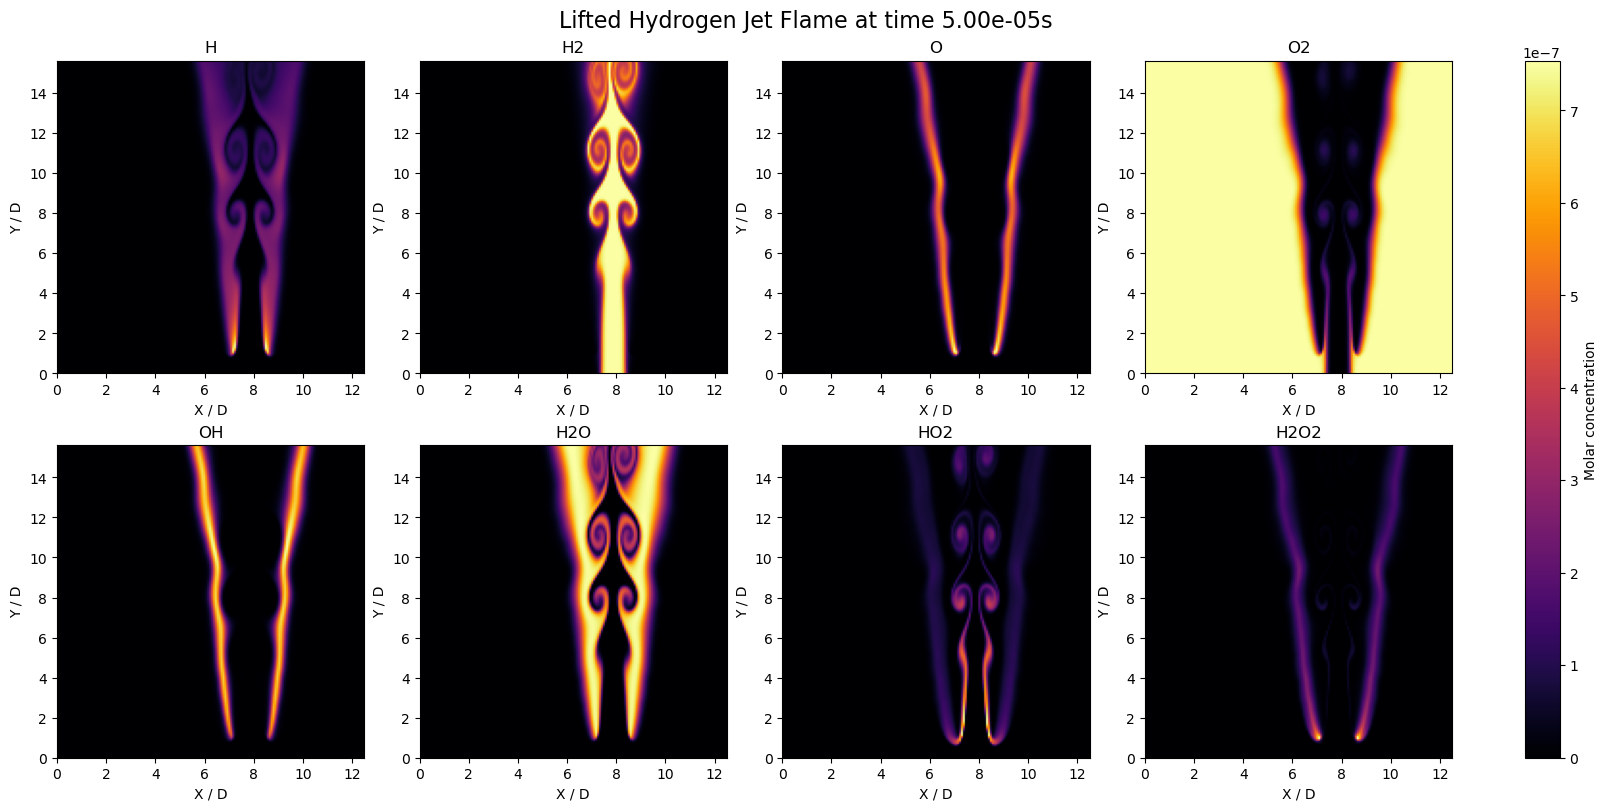

In [7]:
import matplotlib.pyplot as plt
import numpy as np

Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
key, tensor = next(iter(tensors.items()))
for idx, ax in enumerate(axes):
    if idx < tensor.shape[2]:
        im = ax.imshow(
            tensor[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/original_data_t10.png')
plt.show()


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [8]:
tensors_scaled = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=True)


In [9]:
print_statistics(tensors_scaled, component_names)


Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.841125e-20 8.714797e-02 -9.633522e-01 8.609912e-01
YH2             -7.567849e-18 8.127278e-01 -2.647910e+00 3.023160e+00
YO              8.957302e-20 8.202064e-01 -2.394947e+00 2.786432e+00
YO2             2.778246e-19 8.671250e-01 -2.253839e+00 2.830833e+00
YOH             -2.344741e-19 8.129923e-01 -2.358960e+00 2.960161e+00
YH2O            3.100832e-19 7.655634e-01 -2.435521e+00 2.931261e+00
YHO2            5.322376e-20 8.192068e-01 -2.029149e+00 3.364858e+00
YH2O2           1.552945e-17 8.202636e-01 -2.221428e+00 3.607038e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 1

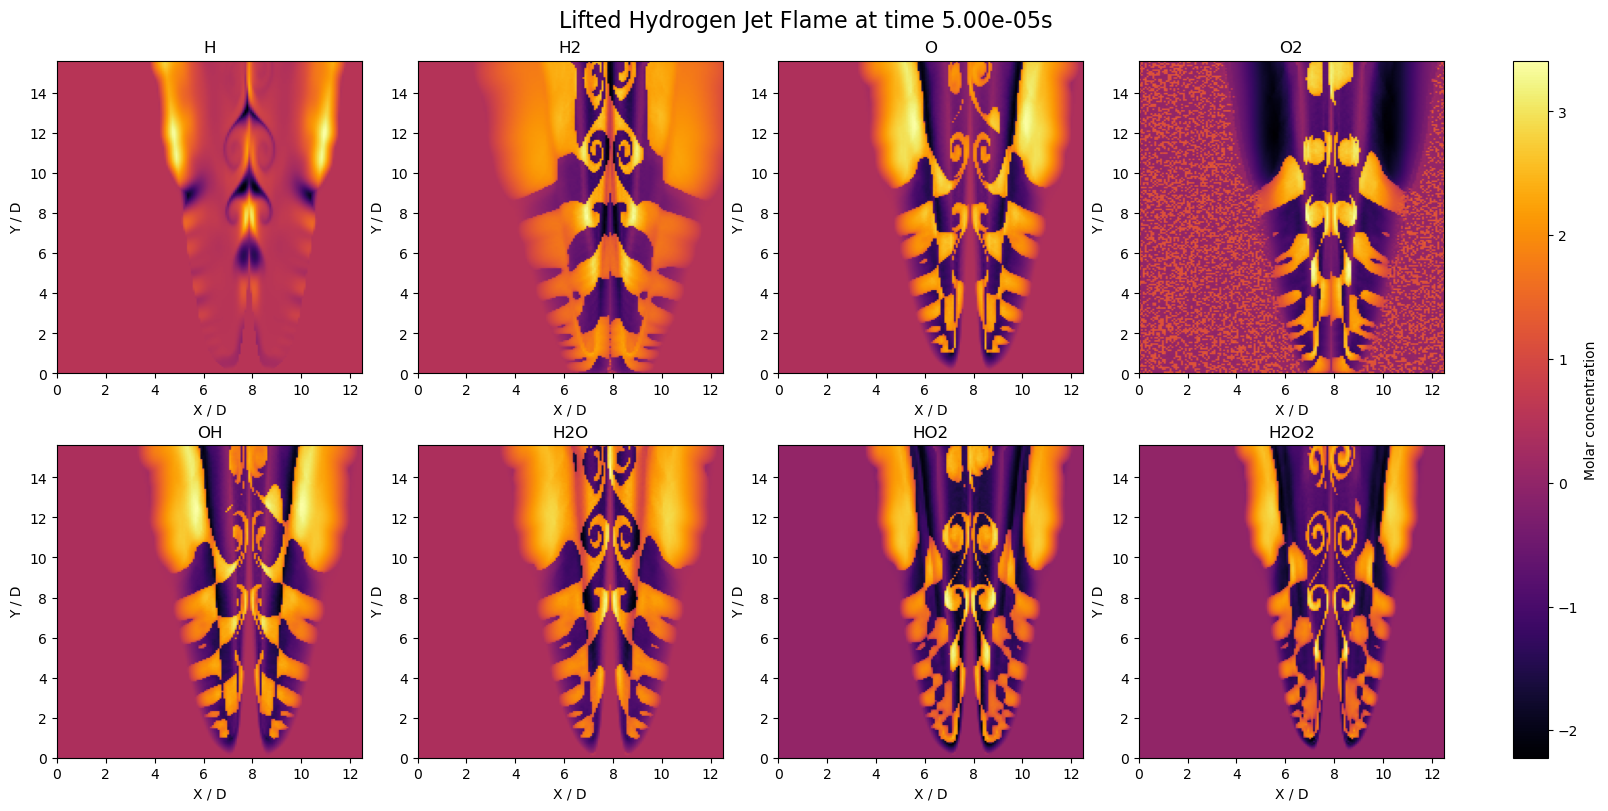

In [10]:
Lx, Ly = 12.5, 15.6        # domain size in D units
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()
tensor_plot =  tensors_scaled[list(tensors_scaled.keys())[0]]
for idx, ax in enumerate(axes):
    if idx < tensor_plot.shape[2]:
        im = ax.imshow(
            tensor_plot[:, :, idx, t],
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        ax.set_title(f"{component_names[idx][1:]}")
        ax.set_xlabel("X / D")
        ax.set_ylabel("Y / D")
    else:
        ax.axis('off')  # turn off unused axes if fewer than 8 components

fig.colorbar(im, ax=axes, orientation='vertical', label="Molar concentration")
plt.savefig(fname = 'README_PLOTS/processed_data_t10.png')
plt.show()


## PCA classica

Per prima cosa bisogna implementare la PCA nella sua forma piu' tradizionale

In [11]:
for dataset_path, tensor in tensors_scaled.items():
    X = np.moveaxis(tensor, 2, -1).reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    
    loadings = V.T  # Now shape is (n_components x n_modes)
    
    summary_data = []
    
    for mode in range(n_species):
        mode_vector = np.abs(loadings[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get top 3 species
        top3_indices = np.argsort(rel_contrib)[:][::-1]
        
        top_species = []
        for idx in top3_indices:
            top_species.append(f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)")
        
        summary_data.append({
            'Mode': mode + 1,
            '1st Species': top_species[0],
            '2nd Species': top_species[1],
            '3rd Species': top_species[2],
            '4rd Species': top_species[3],
            '5rd Species': top_species[4],
            '6rd Species': top_species[5],
            '7rd Species': top_species[6],
            '8rd Species': top_species[7],
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print(f"CONTRIBUTING SPECIES FOR EACH PCA MODE - {dataset_path}")
    print("="*80)
    print(df_summary.to_string(index=False))
    print("="*80)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4rd Species  5rd Species  6rd Species  7rd Species 8rd Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.4%)   YOH (6.9%)    YO 

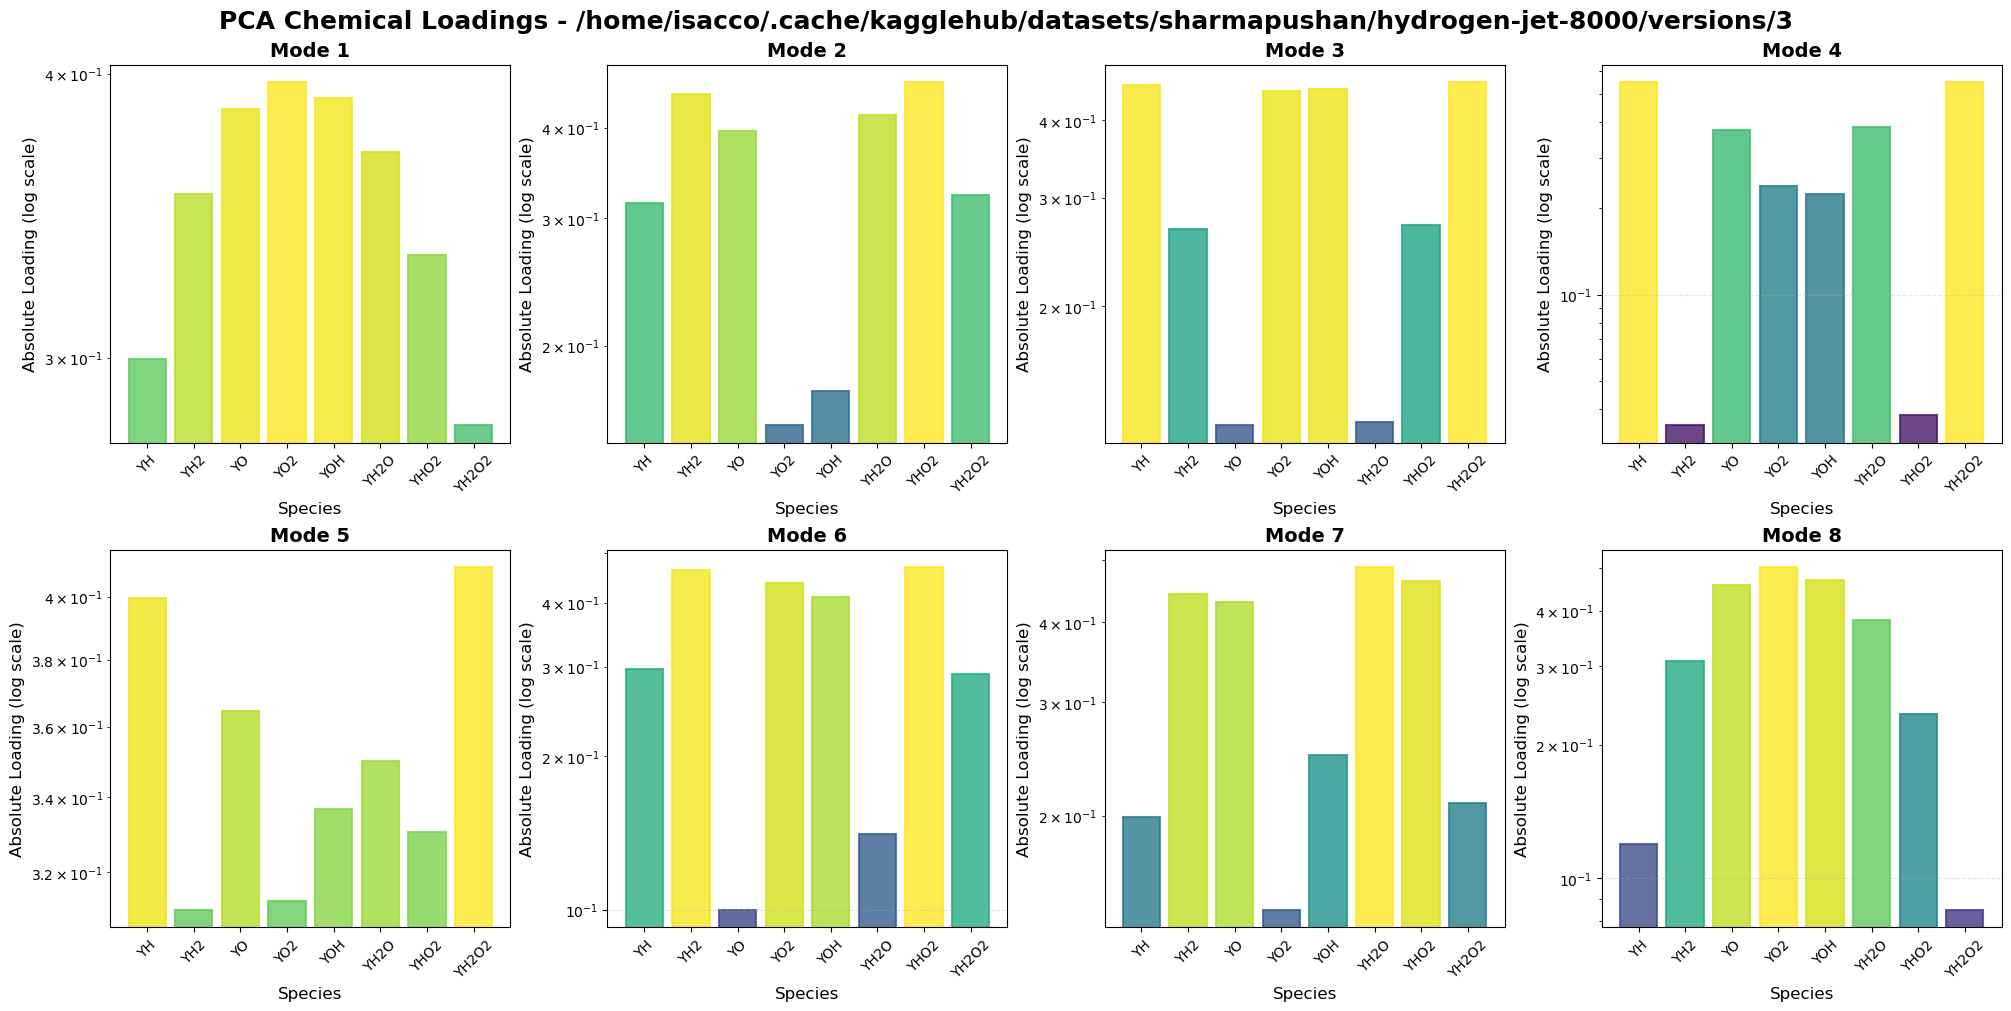

In [12]:
# Visualize PCA loadings for all 8 modes in a 2x4 grid
for dataset_path, tensor in tensors_scaled.items():
    X = tensor.reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U, sigma, V = np.linalg.svd(X, full_matrices=False)
    loadings = V.T  # Now shape is (n_components x n_modes)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"PCA Chemical Loadings - {dataset_path}", fontsize=18, fontweight='bold')
    axes = axes.flatten()
    
    for mode in range(n_species):
        mode_vector = np.abs(loadings[:, mode])
        ax = axes[mode]
        
        bars = ax.bar(component_names, mode_vector, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Color the bars differently based on magnitude
        colors = plt.cm.viridis(mode_vector / mode_vector.max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        ax.set_yscale('log')
        ax.set_title(f'Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Species', fontsize=12)
        ax.set_ylabel('Absolute Loading (log scale)', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.savefig(f'README_PLOTS/pca_chemical_loadings_{dataset_path.split("/")[-1]}.png', dpi=300, bbox_inches='tight')
    plt.show()

(6400000, 8)
Total spatial features: 6400000

Top modes energy content:


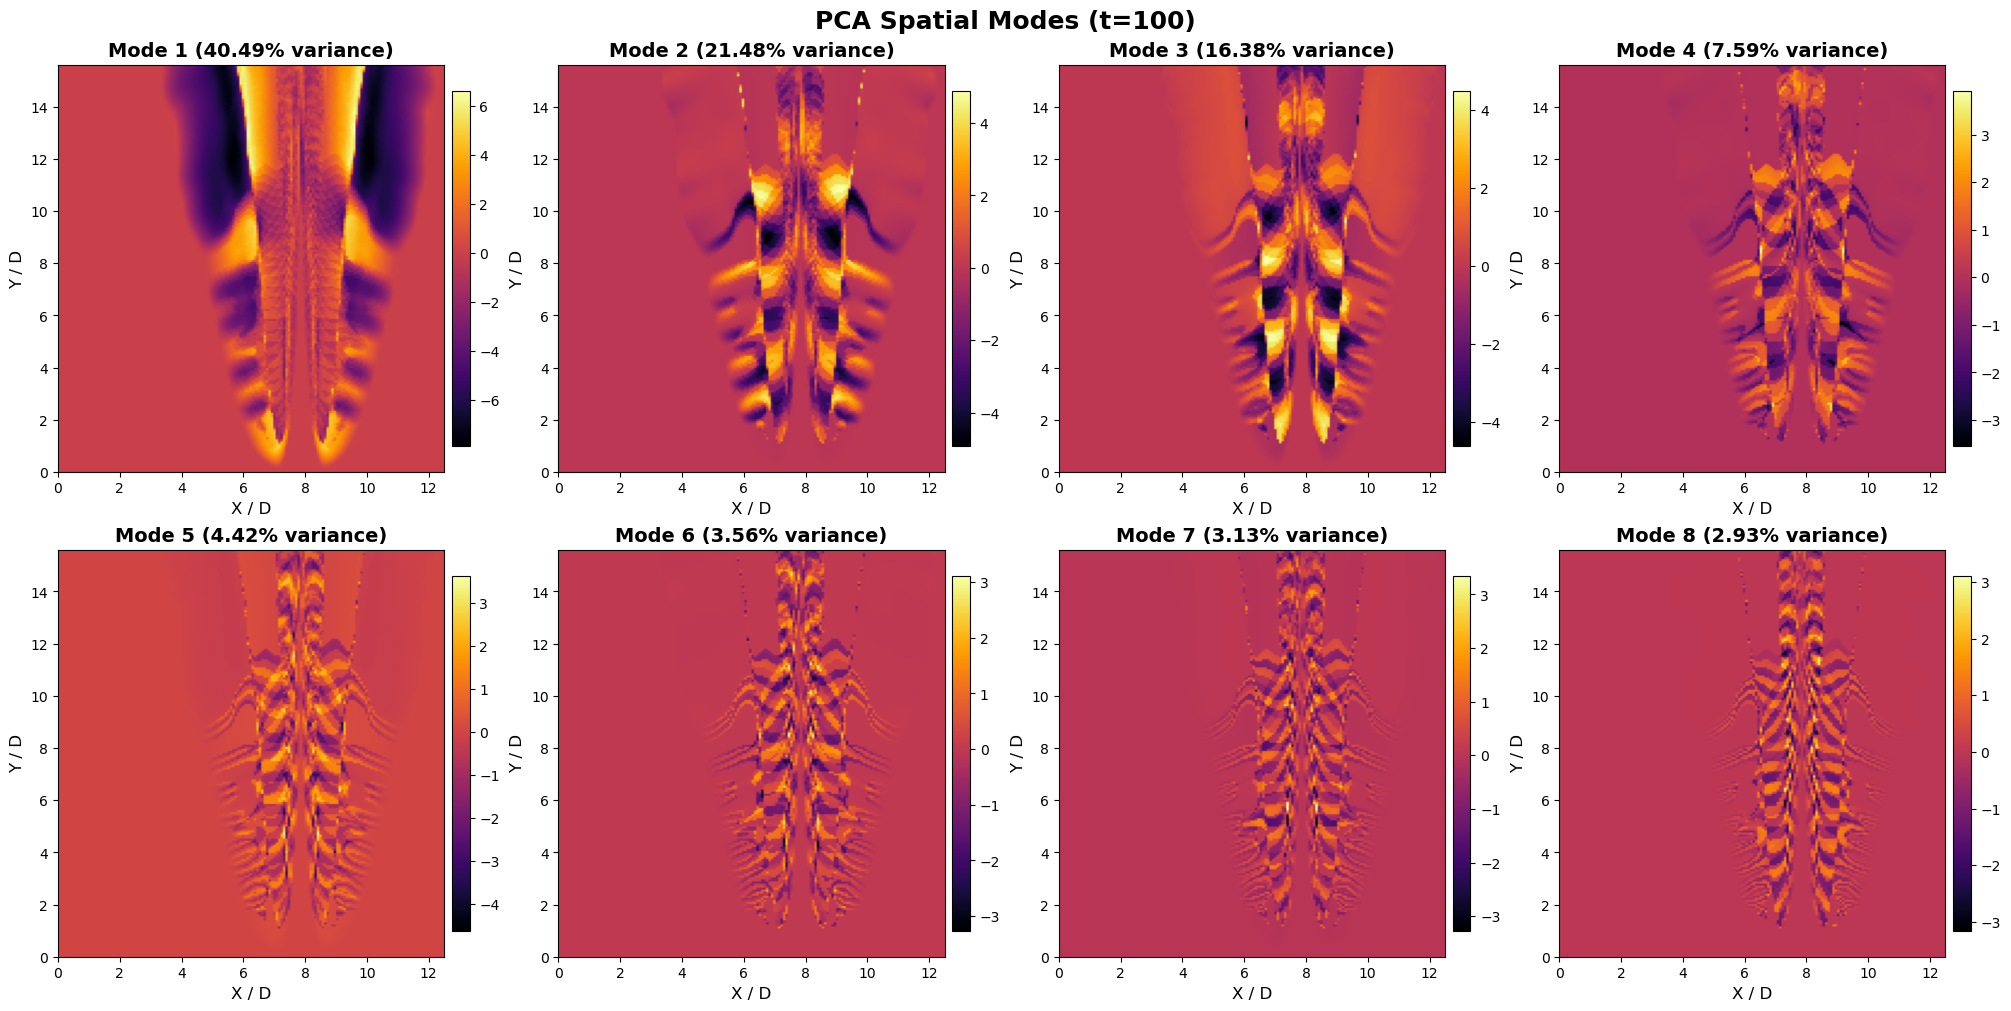

In [12]:
Phi = U
print(U.shape)
T = np.diag(sigma) @ V
energy = sigma**2
energy_fraction = energy / np.sum(energy)
print(f"Total spatial features: {X.shape[0]}")
print("\nTop modes energy content:")

Lx, Ly = 12.5, 15.6  # domain size in D units
t_snapshot = 100  

fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
fig.suptitle(f"PCA Spatial Modes (t={t_snapshot})", fontsize=18, fontweight='bold')

axes = axes.flatten()

for idx in range(n_species):
    phi_mode = (Phi * sigma)[:, idx].reshape(Ny_sub, Nx_sub, 200)
    phi_snapshot = np.flip(phi_mode[:, :, t_snapshot], axis=0)
    
    im = axes[idx].imshow(
        phi_snapshot,
        cmap='inferno',
        extent=[0, Lx, 0, Ly],
        aspect='auto',
        vmin=phi_snapshot.min(),  # Independent min
        vmax=phi_snapshot.max()   # Independent max
    )
    
    axes[idx].set_title(
        f"Mode {idx+1} ({energy_fraction[idx]*100:.2f}% variance)",
        fontsize=14,
        fontweight='bold'
    )
    axes[idx].set_xlabel("X / D", fontsize=12)
    axes[idx].set_ylabel("Y / D", fontsize=12)
    axes[idx].tick_params(labelsize=10)
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axes[idx], orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)

plt.savefig('README_PLOTS/pca_spatial_modes_all.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_4778/786612801.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=12, loc='lower right')


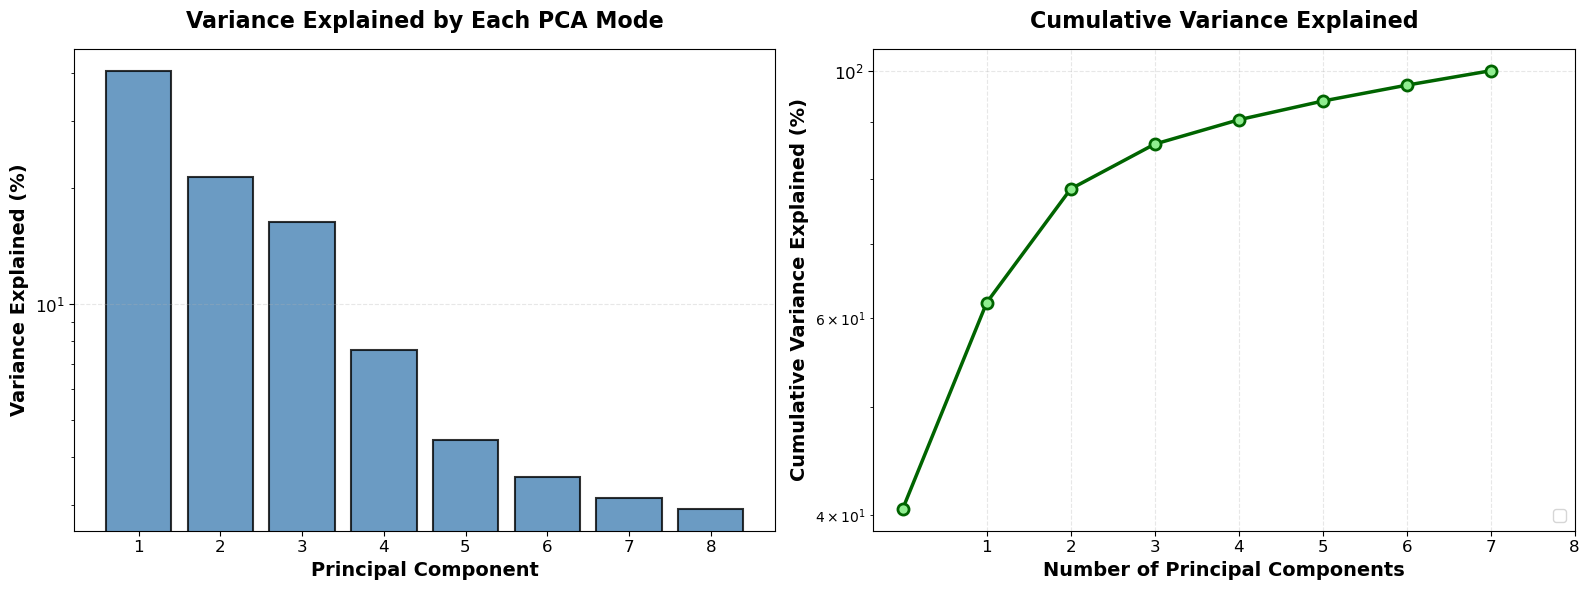


Variance Explained Summary:
  First mode: 40.49%
  First 2 modes: 61.98%
  First 3 modes: 78.36%
  First 4 modes: 85.95%


In [13]:
variance_explained = sigma**2 / np.sum(sigma**2)
cumulative_variance = np.cumsum(variance_explained)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variance explained per mode
ax1.bar(range(1, len(variance_explained) + 1), variance_explained * 100, 
        color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Principal Component', fontsize=14, fontweight='bold')
ax1.set_ylabel('Variance Explained (%)', fontsize=14, fontweight='bold')
ax1.set_title('Variance Explained by Each PCA Mode', fontsize=16, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=12)
ax1.set_xticks(range(1, len(variance_explained) + 1))
ax1.set_yscale("log")
# Cumulative variance explained
ax2.plot(range(0, len(cumulative_variance)), cumulative_variance * 100, 
         marker='o', markersize=8, linewidth=2.5, color='darkgreen', 
         markerfacecolor='lightgreen', markeredgewidth=2, markeredgecolor='darkgreen')
ax2.set_xlabel('Number of Principal Components', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=14, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=16, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12, loc='lower right')
ax2.tick_params(labelsize=12)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.set_yscale("log")

plt.tight_layout()
plt.savefig('README_PLOTS/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance Explained Summary:")
print(f"  First mode: {variance_explained[0]*100:.2f}%")
print(f"  First 2 modes: {cumulative_variance[1]*100:.2f}%")
print(f"  First 3 modes: {cumulative_variance[2]*100:.2f}%")
print(f"  First 4 modes: {cumulative_variance[3]*100:.2f}%")

## HOSVD

Che e' poi preso come caso di fatto equivalente a PCA. Nel caso che si parta a troncare (che ahime' penso si dovra' fare), bisogna che ti metti li' e fai HOOI per essere ben fedele

In [14]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    close = np.allclose(reconst, tensor)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }

print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:16<00:00,  4.03s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 3.390656e-15
----------------------------------------------------------------------------------------------------



(8, 8)


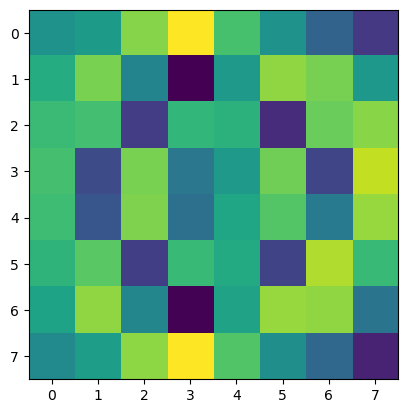

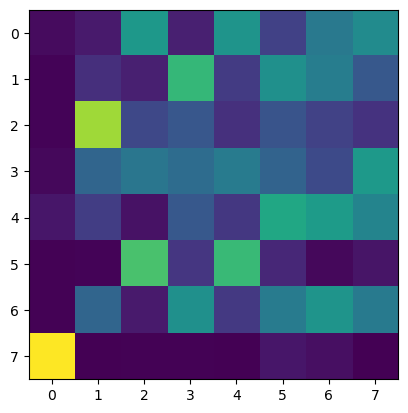

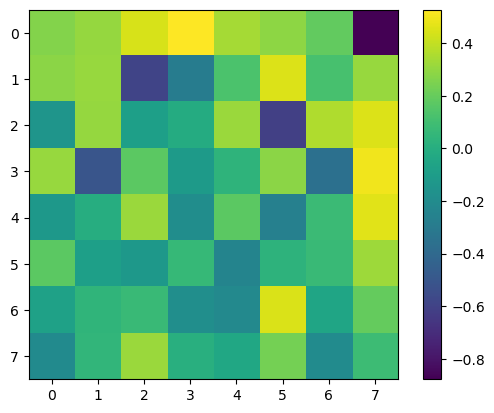

In [15]:
for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        U_x, U_y, U_chem, U_time  = f['factors']
print(loadings.shape)
plt.imshow(np.abs(loadings))
plt.figure()
plt.imshow(np.abs(U_chem).T)
plt.figure()
plt.imshow(np.subtract(np.abs(loadings),np.abs(U_chem)))
plt.colorbar()

In [19]:
print(np.allclose(tl.unfold(tensor, mode=2), X.T))

False


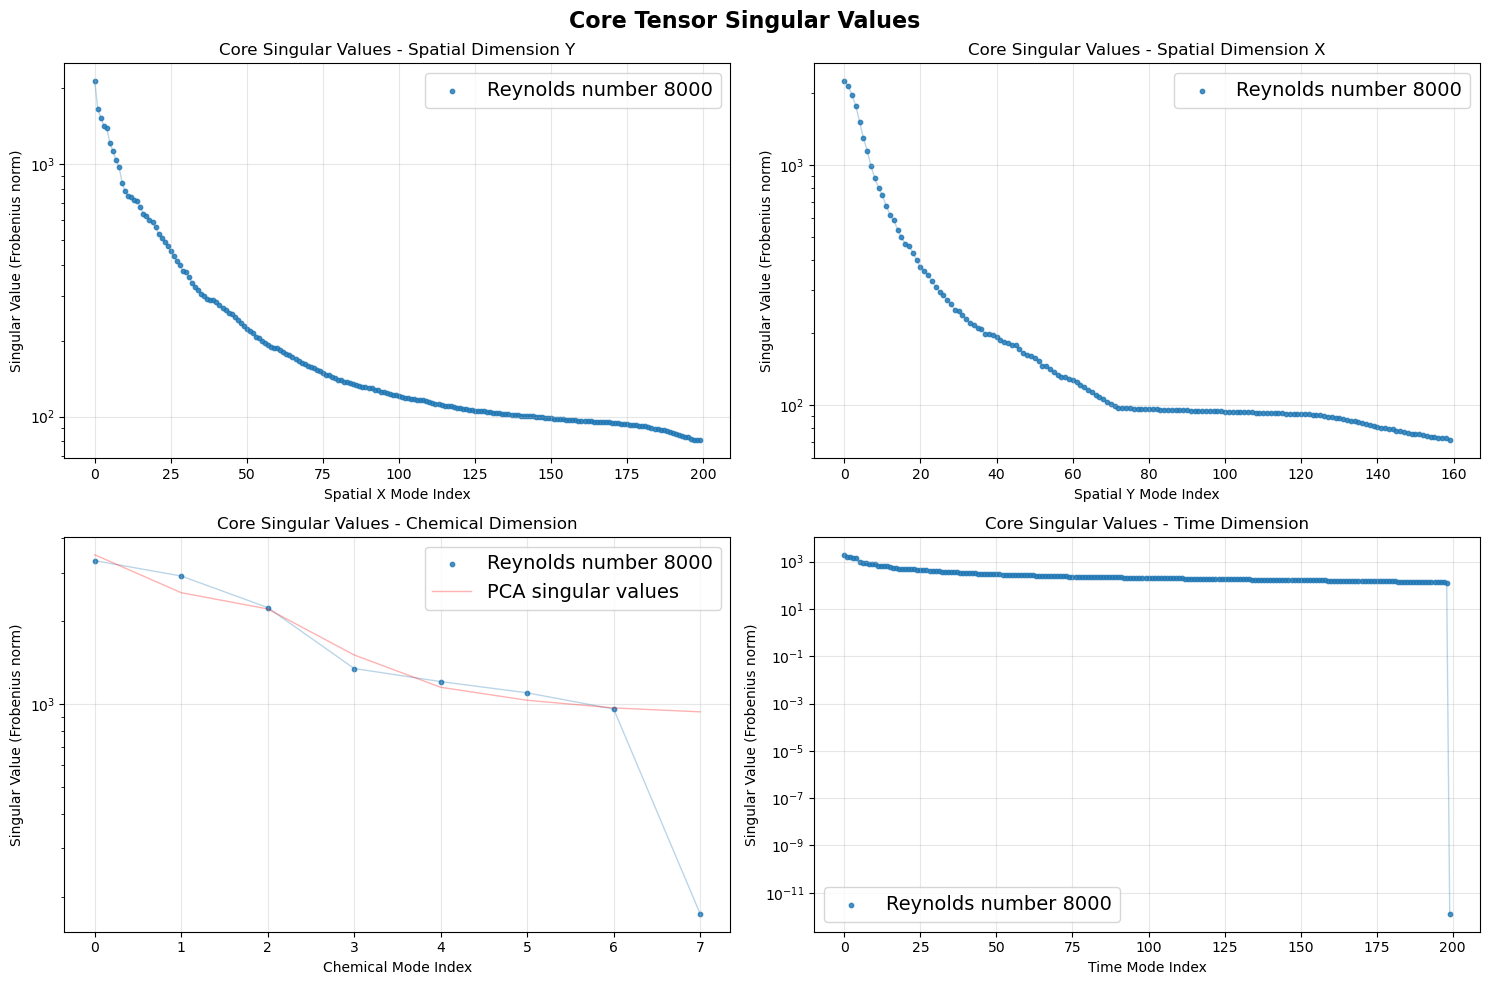

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"
        color = colors[idx]
        
        sv_0 = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
        ax = axes[0, 0]
        ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
        
        sv_1 = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
        ax = axes[0, 1]
        ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
        
        sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
        ax = axes[1, 0]
        ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
        ax.plot(range(len(sv_chem)), sigma, color='red', alpha=0.3, linewidth=1, label="PCA singular values")
        
        sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
        ax = axes[1, 1]
        ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
        ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)

ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

fig.suptitle('Core Tensor Singular Values', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_core_vals.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# Print HOSVD loadings for all 8 species
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    summary_data = []
    
    for mode in range(n_species):
        mode_vector = np.abs(U_chem[:, mode])
        total = np.sum(mode_vector)
        rel_contrib = 100 * mode_vector / total if total > 0 else np.zeros_like(mode_vector)
        
        # Get all species in descending order
        sorted_indices = np.argsort(rel_contrib)[::-1]
        
        species_data = {}
        for rank, idx in enumerate(sorted_indices):
            species_data[f'{rank+1}st Species' if rank == 0 else f'{rank+1}nd Species' if rank == 1 else f'{rank+1}rd Species' if rank == 2 else f'{rank+1}th Species'] = \
                f"{component_names[idx]} ({rel_contrib[idx]:.1f}%)"
        
        summary_data.append({
            'Mode': mode + 1,
            **species_data
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*120)
    print(f"CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - {dataset_path}")
    print("="*120)
    print(df_summary.to_string(index=False))
    print("="*120)


CONTRIBUTING SPECIES FOR EACH HOSVD MODE (Chemical Dimension) - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species  6th Species  7th Species 8th Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.

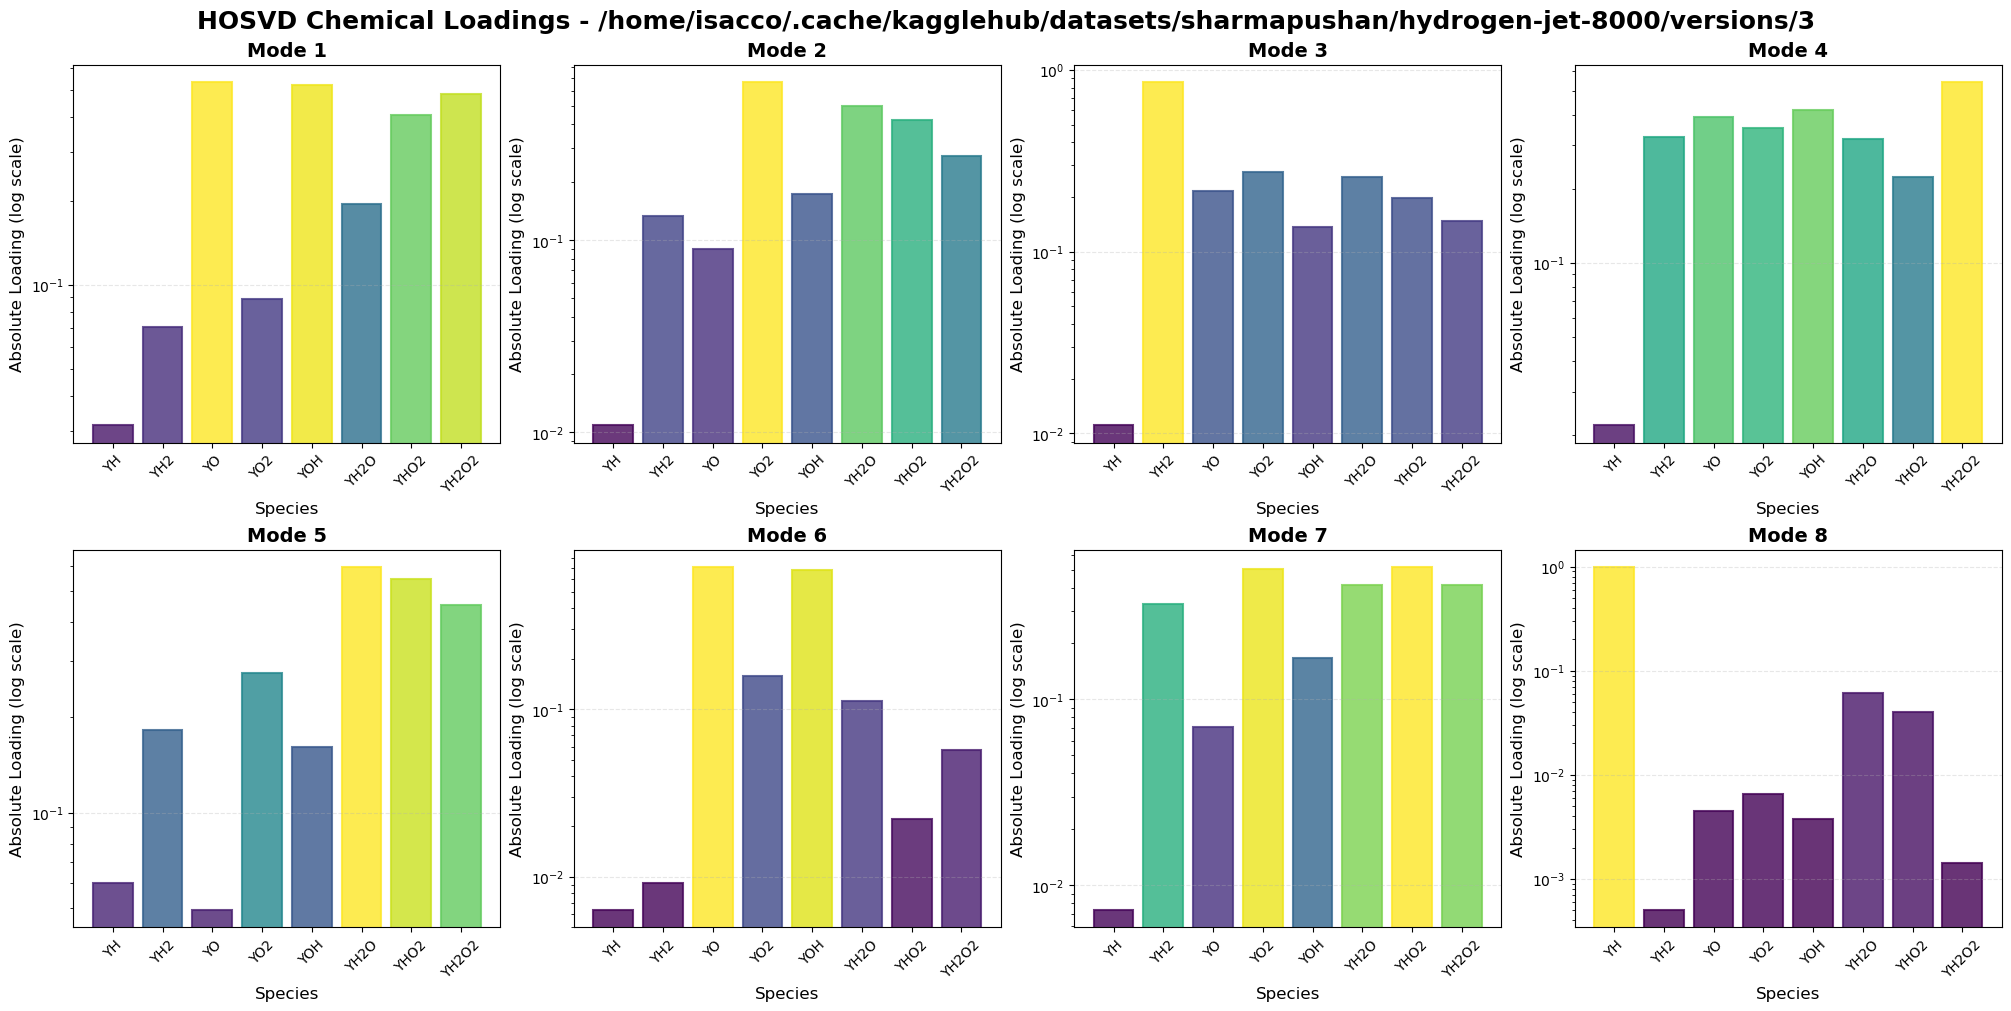

In [18]:
# Visualize HOSVD loadings for all 8 modes in a 2x4 grid
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    U_chem = factors[2]  # Chemical dimension factor (3rd dimension)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Chemical Loadings - {dataset_path}", fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        mode_vector = np.abs(U_chem[:, mode])
        
        ax = axes[mode]
        bars = ax.bar(component_names, mode_vector, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Color the bars differently based on magnitude
        colors = plt.cm.viridis(mode_vector / mode_vector.max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        ax.set_yscale('log')
        ax.set_title(f'Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Species', fontsize=12)
        ax.set_ylabel('Absolute Loading (log scale)', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.savefig(f'README_PLOTS/hosvd_chemical_loadings_{dataset_path.split("/")[-1]}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
for dataset_path, result in decomposition_results.items():
    factors = result['factors']
    core = result['core']
    
    U_y = factors[0]      
    U_x = factors[1]      
    U_chem = factors[2]   
    U_time = factors[3]   
    
    t = 10  # Time snapshot
    Lx, Ly = 12.5, 15.6  # domain size in D units
    time_conversion_factor = 5e-06
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    fig.suptitle(f"HOSVD Reconstruction at t={t * time_conversion_factor:.2e}s using Chemical Modes", 
                 fontsize=18, fontweight='bold')
    
    axes = axes.flatten()
    
    for mode in range(8):
        reconstructed = multi_mode_dot(core, [U_y, U_x,U_chem[:, mode], U_time], modes=[0,1,2,3])
        reconstructed_t10 = reconstructed[:, :, t]        
        ax = axes[mode]
        im = ax.imshow(
            reconstructed_t10,
            cmap='inferno',
            origin='lower',
            extent=[0, Lx, 0, Ly],
            aspect='auto'
        )
        
        ax.set_title(f'Chemical Mode {mode + 1}', fontsize=14, fontweight='bold')
        ax.set_xlabel("X / D", fontsize=12)
        ax.set_ylabel("Y / D", fontsize=12)
        ax.tick_params(labelsize=10)
        
        # Add colorbar for each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
        cbar.ax.tick_params(labelsize=10)
    
    plt.savefig(f'README_PLOTS/hosvd_reconstruction_t10_chemical_modes.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
plot_reconstruction_comparison(
    U_PCA, sigma_PCA, V_PCA, 
    Nx_sub, Ny_sub, n_species, n_snapshots,
    decomposition_results, 
    dataset_path,
    n_modes=8, 
    t_snapshot=10,
    Lx=12.5, 
    Ly=15.6,
    time_conversion_factor=5e-06
)

NameError: name 'U_PCA' is not defined

In [ ]:
#scommenta per fare la gif
#create_hosvd_reconstruction_gif(decomposition_results, multi_mode_dot, num_snapshots=50, output_path="./temporal_mean_flow.gif")

Reconstructing tensors for all chemical modes...


Chemical modes: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Computing min/max values for each chemical mode...
Global value range: [-4.79e+00, 5.90e+00]
Generating frames for gif...


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


Creating gif at ./temporal_mean_flow.gif...
Cleaning up temporary files...
Gif saved to ./temporal_mean_flow.gif


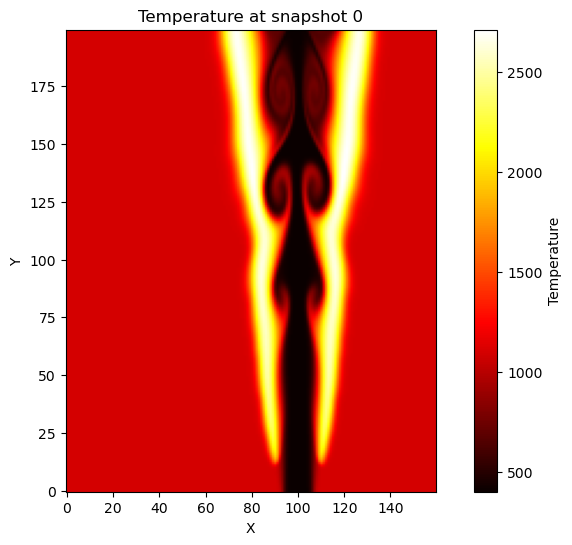

In [ ]:
# Qua ti resta da fare una analisi che abbia effettivamente senso
with open(f"{data_paths[0]}/info.json", 'r') as f:
    metadata = json.load(f)

T_tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, 1, n_snapshots))

for t_idx in range(n_snapshots):
    filename = metadata['local'][t_idx]['T_K filename']  # or whatever key for temperature
    data = np.fromfile(f"{data_paths[0]}/{filename}", dtype='<f4').reshape(Ny, Nx)
    T_tensor[:, :, 0, t_idx] = data[::subsample_y, ::subsample_x]

snapshot_idx = 0
plt.figure(figsize=(10, 6))
plt.imshow(T_tensor[:, :, 0, snapshot_idx], cmap='hot', origin='lower')
plt.colorbar(label='Temperature')
plt.title(f'Temperature at snapshot {snapshot_idx}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [54]:
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

with open(f"{data_paths[0]}/info.json", 'r') as f:
    metadata = json.load(f)

T_tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, 1, n_snapshots))
for t_idx in range(n_snapshots):
    filename = metadata['local'][t_idx]['T_K filename']
    data = np.fromfile(f"{data_paths[0]}/{filename}", dtype='<f4').reshape(Ny, Nx)
    T_tensor[:, :, 0, t_idx] = data[::subsample_y, ::subsample_x]

T_spatial_mean = T_tensor.mean(axis=(0, 1), keepdims=True)
T_tensor = T_tensor - T_spatial_mean

T_temporal_mean = T_tensor.mean(axis=3, keepdims=True)
T_fluctuations = T_tensor - T_temporal_mean

ny, nx, nz, nt = T_fluctuations.shape
T_reshaped = T_fluctuations.reshape(-1, nt).T  # (n_snapshots, Ny*Nx*1)

# Applica StandardScaler
scaler = StandardScaler()
T_scaled = scaler.fit_transform(T_reshaped)  # (n_snapshots, Ny*Nx*1)

# Riporta alla forma originale
T_preprocessed = T_scaled.T.reshape(ny, nx, nz, nt)

print(f"Shape finale: {T_preprocessed.shape}")
print(f"Media globale (dovrebbe essere ~0): {T_preprocessed.mean():.2e}")
print(f"Std globale (dovrebbe essere ~1): {T_preprocessed.std():.4f}")
print(f"Min/Max: [{T_preprocessed.min():.2f}, {T_preprocessed.max():.2f}]")

print(f"\nMedia per feature (dovrebbe essere tutto ~0): "
      f"min={T_reshaped.mean(axis=0).min():.2e}, max={T_reshaped.mean(axis=0).max():.2e}")
print(f"Std per feature (dovrebbe essere tutto ~1): "
      f"min={scaler.scale_.min():.4f}, max={scaler.scale_.max():.4f}")

Shape finale: (200, 160, 1, 200)
Media globale (dovrebbe essere ~0): -7.90e-19
Std globale (dovrebbe essere ~1): 1.0000
Min/Max: [-7.51, 10.23]

Media per feature (dovrebbe essere tutto ~0): min=-2.69e-13, max=2.41e-13
Std per feature (dovrebbe essere tutto ~1): min=5.8667, max=651.4966


In [55]:
from matplotlib.animation import FuncAnimation, PillowWriter

start_idx = 0  # primo snapshot da visualizzare
end_idx = min(100, n_snapshots)  
fps = 10  # frame per secondo

T_plot = T_preprocessed[:, :, 0, start_idx:end_idx]
vmax = np.percentile(np.abs(T_plot), 99)  # usa il 99° percentile per evitare outlier
vmin = -vmax

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(T_plot[:, :, 0], 
               cmap='inferno',
               vmin=vmin, vmax=vmax,
               origin='lower',
               aspect='auto')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('ΔT [K]', fontsize=12)

def update(frame):
    im.set_data(T_plot[:, :, frame])
    ax.set_title(f'Temperatura - Snapshot {start_idx + frame}', 
                 fontsize=14, fontweight='bold')
    return [im]

anim = FuncAnimation(fig, update, frames=end_idx-start_idx, 
                     interval=1000/fps, blit=True)

output_path = 'temperature_fluctuations.gif'
writer = PillowWriter(fps=fps)
anim.save(output_path, writer=writer, dpi=100)
print(f"GIF salvata in: {output_path}")

plt.close()

GIF salvata in: temperature_fluctuations.gif


# Ricostruzioni e Errori

In questa sezione confrontiamo sistematicamente le ricostruzioni di PCA e HOSVD, analizzando:
1. **Metriche di errore** (MSE, RMSE, errore relativo) in funzione del numero di modi trattenuti
2. **Convergenza dell'errore** al variare del troncamento
3. **Confronto visivo** tra originale, ricostruzioni PCA/HOSVD ed errori
4. **Analisi per specie** per identificare quali componenti chimiche sono meglio approssimate

**Nota**: HOSVD è utilizzato senza ottimizzazione iterativa (HOOI). Per applicazioni pratiche con forte troncamento, HOOI migliorerebbe i risultati.

In [ ]:
# Define error metrics
def compute_error_metrics(original, reconstructed):
    """
    Compute comprehensive error metrics between original and reconstructed tensors.
    
    Returns:
        dict: Dictionary containing MSE, RMSE, relative error, and max absolute error
    """
    diff = original - reconstructed
    
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    relative_error = np.linalg.norm(diff) / np.linalg.norm(original)
    max_abs_error = np.max(np.abs(diff))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'Relative Error': relative_error,
        'Max Absolute Error': max_abs_error
    }

def compute_species_errors(original, reconstructed, component_names):
    """
    Compute error metrics for each chemical species separately.
    
    Returns:
        pd.DataFrame: DataFrame with error metrics per species
    """
    species_errors = []
    
    for i, species in enumerate(component_names):
        orig_species = original[:, :, i, :]
        recon_species = reconstructed[:, :, i, :]
        
        metrics = compute_error_metrics(orig_species, recon_species)
        metrics['Species'] = species
        species_errors.append(metrics)
    
    return pd.DataFrame(species_errors)

In [ ]:
PCA_ENERGY_THRESHOLD = 0.95  

original_tensor = next(iter(tensors_scaled.values()))
pca_energy = sigma**2
pca_cumulative_energy = np.cumsum(pca_energy) / np.sum(pca_energy)
pca_n_modes = np.argmax(pca_cumulative_energy >= PCA_ENERGY_THRESHOLD) + 1

In [ ]:
print(f"Keeping {pca_n_modes} modes out of {len(sigma)} (95% energy)")
U_truncated = Phi[:, :pca_n_modes]
sigma_truncated = sigma[:pca_n_modes]
Vt_truncated = V[:pca_n_modes, :]
reconstructed_unfolded = U_truncated @ np.diag(sigma_truncated) @ Vt_truncated
reconstructed_tensor = reconstructed_unfolded.reshape(original_tensor.shape)
reconstruction_error = np.linalg.norm(original_tensor - reconstructed_tensor) / np.linalg.norm(original_tensor)
print(f"Relative reconstruction error: {reconstruction_error:.4f}")

original_size = original_tensor.size
compressed_size = (U_truncated.size + sigma_truncated.size + Vt_truncated.size)
compression_ratio = original_size / compressed_size

print(f"Original size: {original_size} elements")
print(f"Compressed size: {compressed_size} elements")
print(f"Compression ratio: {compression_ratio:.2f}x")
print(f"Storage reduction: {(1 - 1//compression_ratio)*100:.1f}%")

Keeping 1 modes out of 8 (95% energy)
Relative reconstruction error: 0.1245
Original size: 51200000 elements
Compressed size: 6400009 elements
Compression ratio: 8.00x
Storage reduction: 100.0%


Reynolds number 8000 - Elbows: X=10, Y=10, Chem=2, Time=6


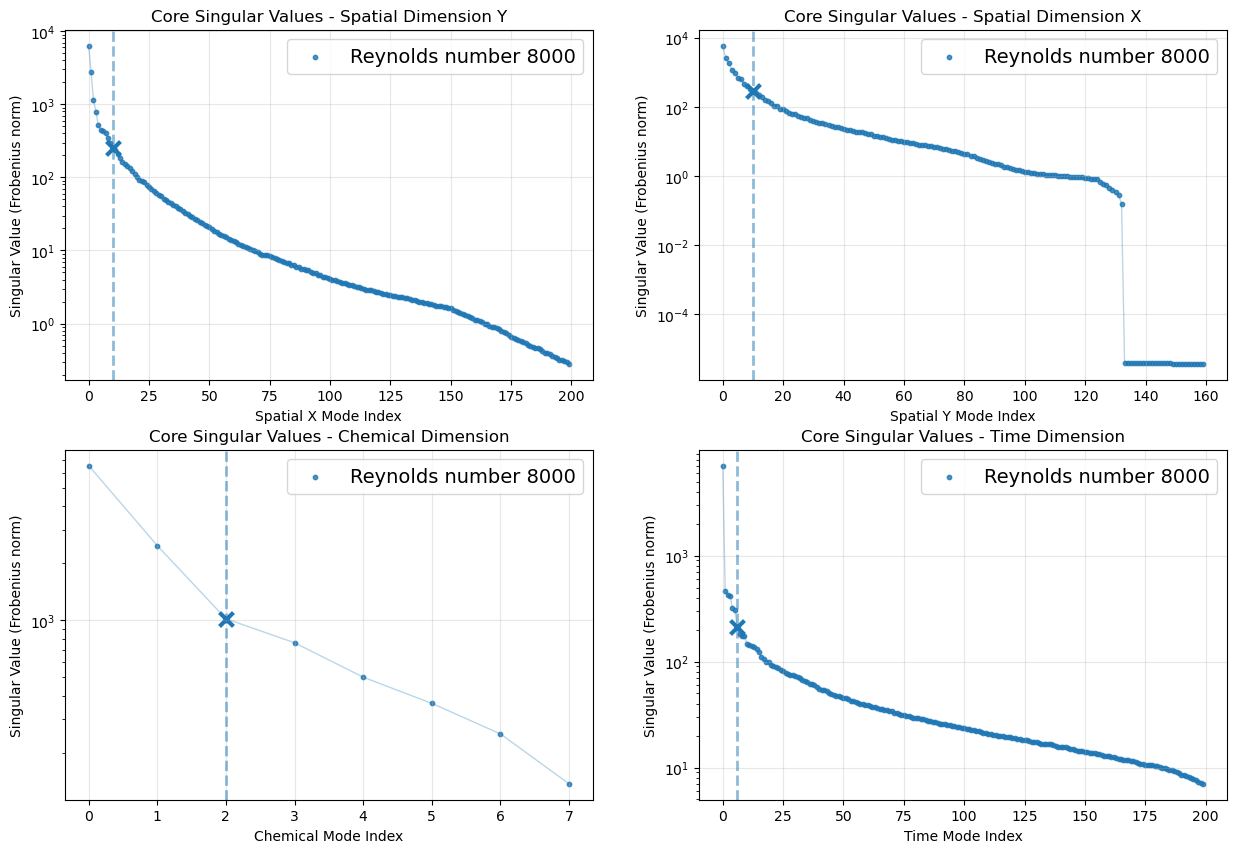

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(decomposition_results)))

for idx, (key, f) in enumerate(decomposition_results.items()):
    core = f['core']
    dataset_name = f"Reynolds number {key.split('-')[-1][:4]}"
    color = colors[idx]
    
    # Mode 0 - Spatial X
    sv_0 = np.array([np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])])
    # Find elbow: maximum perpendicular distance from line connecting first and last point
    n_points = len(sv_0)
    # Normalize coordinates
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_0 - sv_0.min()) / (sv_0.max() - sv_0.min())
    # Calculate perpendicular distances
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_0 = np.argmax(distances)
    
    ax = axes[0, 0]
    ax.scatter(range(len(sv_0)), sv_0, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_0)), sv_0, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_0, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_0], [sv_0[elbow_0]], color=color, s=100, marker='x', linewidths=3)
    
    # Mode 1 - Spatial Y
    sv_1 = np.array([np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])])
    n_points = len(sv_1)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_1 - sv_1.min()) / (sv_1.max() - sv_1.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_1 = np.argmax(distances)
    
    ax = axes[0, 1]
    ax.scatter(range(len(sv_1)), sv_1, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_1)), sv_1, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_1, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_1], [sv_1[elbow_1]], color=color, s=100, marker='x', linewidths=3)
    
    sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])])
    n_points = len(sv_chem)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_chem - sv_chem.min()) / (sv_chem.max() - sv_chem.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_chem = np.argmax(distances)
    
    ax = axes[1, 0]
    ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_chem, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_chem], [sv_chem[elbow_chem]], color=color, s=100, marker='x', linewidths=3)
    
    sv_time = np.array([np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])])
    n_points = len(sv_time)
    x_norm = np.arange(n_points) / (n_points - 1)
    y_norm = (sv_time - sv_time.min()) / (sv_time.max() - sv_time.min())
    distances = np.abs((y_norm[-1] - y_norm[0]) * x_norm - (x_norm[-1] - x_norm[0]) * y_norm + x_norm[-1] * y_norm[0] - y_norm[-1] * x_norm[0])
    distances /= np.sqrt((y_norm[-1] - y_norm[0])**2 + (x_norm[-1] - x_norm[0])**2)
    elbow_time = np.argmax(distances)
    
    ax = axes[1, 1]
    ax.scatter(range(len(sv_time)), sv_time, color=color, s=10, alpha=0.8, label=dataset_name)
    ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1)
    ax.axvline(elbow_time, color=color, linestyle='--', alpha=0.5, linewidth=2)
    ax.scatter([elbow_time], [sv_time[elbow_time]], color=color, s=100, marker='x', linewidths=3)
    
    print(f"{dataset_name} - Elbows: X={elbow_0}, Y={elbow_1}, Chem={elbow_chem}, Time={elbow_time}")
ax = axes[0, 0]
ax.set_xlabel('Spatial X Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension Y') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[0, 1]
ax.set_xlabel('Spatial Y Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Spatial Dimension X') #attenzione
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 0]
ax.set_xlabel('Chemical Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Chemical Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')

ax = axes[1, 1]
ax.set_xlabel('Time Mode Index')
ax.set_ylabel('Singular Value (Frobenius norm)')
ax.set_title('Core Singular Values - Time Dimension')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=14, loc='best')
